# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
import random

In [4]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

<IPython.core.display.Javascript object>


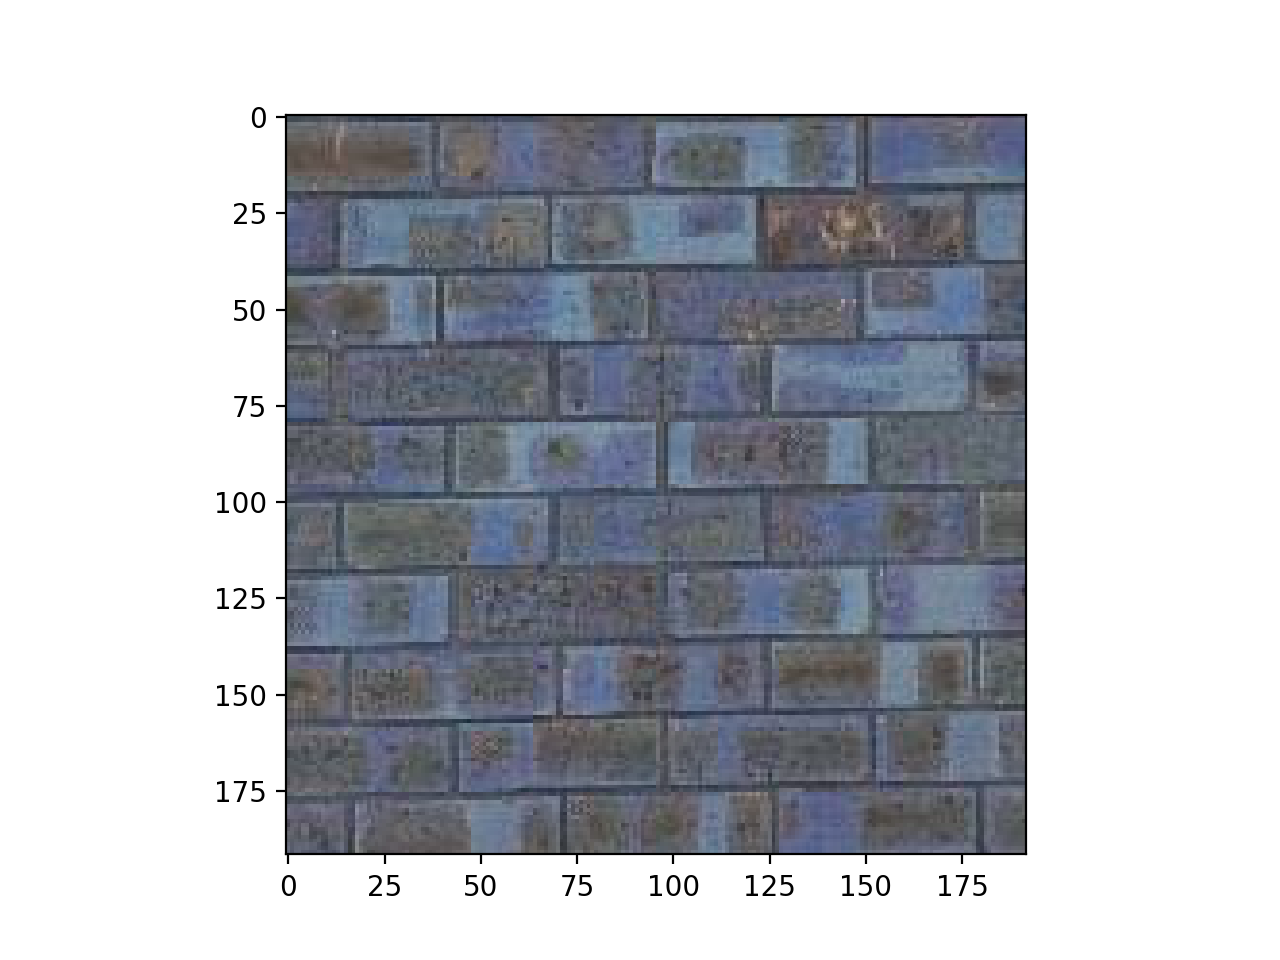

In [5]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)

plt.imshow(sample_img)

In [4]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    
    result = np.zeros((out_size, out_size, 3))
    
    patches = out_size//patch_size
    (r, c, _) = sample.shape
    row_range = r-patch_size
    col_range = c-patch_size
    
    for i in range(patches):
        for j in range(patches):
            loc_r = random.randint(0, row_range)
            loc_c = random.randint(0, col_range)
            
            result[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] \
                = sample[loc_r:loc_r+patch_size, loc_c:loc_c+patch_size, :].copy()
    
    return result
    

(333, 500, 3)


[]

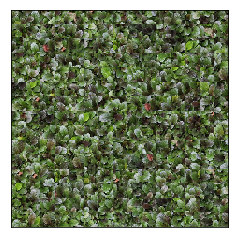

In [5]:
out_size = 600  # feel free to change to debug
patch_size = 40 # feel free to change to debug
print(sample_img.shape)
res = quilt_random(sample_img, out_size, patch_size)
res = res.astype(np.uint8)

res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,1)
axes.imshow(res)
axes.set_xticks([])
axes.set_yticks([])

### Part II: Overlapping Patches (30 pts)

In [6]:
def ssd_patch(T, M, I):
    T.astype(np.float64)
    M.astype(np.float64)
    I.astype(np.float64)
    T = T/15
    I = I/15
    
    channel1 = ((M[:,:,0]*T[:,:,0])**2).sum() - 2 * cv2.filter2D(I[:,:,0], ddepth=-1, \
                kernel = M[:,:,0]*T[:,:,0]) + cv2.filter2D(I[:,:,0] ** 2, ddepth=-1, kernel=M[:,:,0])
    channel2 = ((M[:,:,1]*T[:,:,1])**2).sum() - 2 * cv2.filter2D(I[:,:,1], ddepth=-1, \
                kernel = M[:,:,1]*T[:,:,1]) + cv2.filter2D(I[:,:,1] ** 2, ddepth=-1, kernel=M[:,:,1])
    channel3 = ((M[:,:,2]*T[:,:,2])**2).sum() - 2 * cv2.filter2D(I[:,:,2], ddepth=-1, \
                kernel = M[:,:,2]*T[:,:,2]) + cv2.filter2D(I[:,:,2] ** 2, ddepth=-1, kernel=M[:,:,2])
    (r, c) = channel1.shape
    
    ssd = np.zeros((r, c))
    ssd[:,:] = channel1 + channel2 + channel3
    
    
    return np.absolute(ssd[:,:])


In [7]:
def choose_sample(cost, tol):
    minc = np.amin(cost)
    row, col = np.where(cost <= minc*(1+tol))
    index = list(zip(list(row), list(col)))
    return random.choice(index)

In [8]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    # Todo 
    mask_left = np.zeros((patch_size, patch_size, 3))
    mask_left[:, :overlap,:] = 1
    
    mask_top = np.zeros((patch_size, patch_size, 3))
    mask_top[:overlap, :, :] = 1
    
    mask_other = np.zeros((patch_size, patch_size, 3))
    mask_other[:, :overlap, :] = 1
    mask_other[:overlap, :, :] = 1
    
    result = np.zeros((out_size, out_size, 3))
    rows = (out_size-overlap) // (patch_size-overlap)
    cols = (out_size-overlap) // (patch_size-overlap)

    loc_r = random.randint(0, sample.shape[0]-patch_size)
    loc_c = random.randint(0, sample.shape[1]-patch_size)
    
    result[:patch_size, :patch_size, :] = sample[loc_r:loc_r+patch_size, loc_c:loc_c+patch_size, :].copy()
    
    for i in range(1, rows):
        ssd = ssd_patch(result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, \
                               : patch_size, :], mask_top, sample)
        ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        (row, col) = choose_sample(ssd, tol)
        #plt.imshow(result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, : patch_size, :])
        result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, : patch_size, :] = \
            sample[row:row+patch_size, col:col+patch_size,:].copy()
            
    for i in range(1, cols):
        ssd = ssd_patch(result[:patch_size, i*(patch_size-overlap):i*(patch_size-overlap)+patch_size,\
                               :], mask_left, sample)
        ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        (row, col) = choose_sample(ssd, tol)
        result[: patch_size, i*(patch_size-overlap):i*(patch_size-overlap) + patch_size, :] = \
            sample[row:row+patch_size, col:col+patch_size,:].copy()
    
    for i in range(1, cols):
        for j in range(1, rows):
            ssd = ssd_patch(result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, \
                                   j*(patch_size-overlap):j*(patch_size-overlap)+patch_size, :], \
                                   mask_other, sample)
            ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
            (row, col) = choose_sample(ssd, tol)
            result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, \
                   j*(patch_size-overlap):j*(patch_size-overlap)+patch_size, :] = \
                    sample[row:row+patch_size, col:col+patch_size,:].copy()
            
    return result


[]

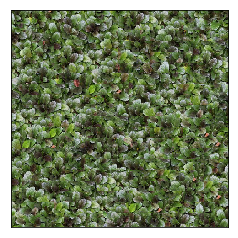

In [9]:

res = quilt_simple(sample_img, 610, 40, 10, 0.001) #feel free to change parameters to get best results

res = res.astype(np.uint8)

res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,1)
axes.imshow(res)
axes.set_xticks([])
axes.set_yticks([])

### Part III: Seam Finding (20 pts)


In [10]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [8]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    mask_left = np.zeros((patch_size, patch_size, 3))
    mask_left[:, :overlap,:] = 1
    
    mask_top = np.zeros((patch_size, patch_size, 3))
    mask_top[:overlap, :, :] = 1
    
    mask_other = np.zeros((patch_size, patch_size, 3))
    mask_other[:, :overlap, :] = 1
    mask_other[:overlap, :, :] = 1
    
    ones1 = np.ones((overlap, patch_size, 3))
    ones2 = np.ones((patch_size, overlap, 3))
    
    result = np.zeros((out_size, out_size, 3))
    rows = (out_size-overlap) // (patch_size-overlap)
    cols = (out_size-overlap) // (patch_size-overlap)

    loc_r = random.randint(0, sample.shape[0]-patch_size)
    loc_c = random.randint(0, sample.shape[1]-patch_size)
    
    result[:patch_size, :patch_size, :] = sample[loc_r:loc_r+patch_size, loc_c:loc_c+patch_size, :].copy()
    
    for i in range(1, rows):
        
        replace = result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, : patch_size, :]
        ssd = ssd_patch(replace, mask_top, sample)
        ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        (row, col) = choose_sample(ssd, tol)
        new_patch = sample[row:row+patch_size, col:col+patch_size,:].copy()
        
        #diff = ssd_patch(new_patch[:overlap, :patch_size, :], replace[:overlap,: patch_size, :], ones1)
        
        diff = replace[:overlap,: patch_size, :]**2 - new_patch[:overlap, :patch_size, :]**2
        diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
        
        mask = cut(diff)
        
        mask = mask.astype(np.uint8)
        
        new_patch[:overlap,:patch_size,0] *= mask
        new_patch[:overlap,:patch_size,1] *= mask
        new_patch[:overlap,:patch_size,2] *= mask
        
        inv_mask = np.ones(mask.shape)-mask
        
        replace[:overlap,:patch_size,0] *= inv_mask
        replace[:overlap,:patch_size,1] *= inv_mask
        replace[:overlap,:patch_size,2] *= inv_mask
        
        replace += new_patch
            
    for i in range(1, cols):
        replace = result[:patch_size, i*(patch_size-overlap):i*(patch_size-overlap)+patch_size,:]
        ssd = ssd_patch(replace, mask_left, sample)
        ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        (row, col) = choose_sample(ssd, tol)
        new_patch = sample[row:row+patch_size, col:col+patch_size,:].copy()
        
        diff = replace[: patch_size,:overlap, :]**2 - new_patch[:patch_size,:overlap, :]**2
        diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
        #diff = ssd_patch(new_patch[:patch_size,:overlap, :], replace[: patch_size,:overlap, :], ones2)
        mask = cut(diff)
        
        mask = mask.astype(np.uint8)
        
        new_patch[:patch_size,:overlap,0] *= mask
        new_patch[:patch_size,:overlap,1] *= mask
        new_patch[:patch_size,:overlap,2] *= mask
        
        inv_mask = np.ones(mask.shape)-mask
        
        replace[:patch_size,:overlap,0] *= inv_mask
        replace[:patch_size,:overlap,1] *= inv_mask
        replace[:patch_size,:overlap,2] *= inv_mask
        
        
        
        replace += new_patch
            
    
    for i in range(1, cols):
        for j in range(1, rows):
            replace = result[i*(patch_size-overlap):i*(patch_size-overlap)+patch_size, \
                                   j*(patch_size-overlap):j*(patch_size-overlap)+patch_size, :]
            ssd = ssd_patch(replace, mask_other, sample)
            ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
            (row, col) = choose_sample(ssd, tol)
            new_patch = sample[row:row+patch_size, col:col+patch_size,:].copy()
            
            diff = replace[:overlap,: patch_size, :]**2 - new_patch[:overlap, :patch_size, :]**2
            diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
            #diff = ssd_patch(new_patch[:overlap, :patch_size, :], replace[:overlap,: patch_size, :], ones1)
            mask1 = cut(diff)
            
            
            diff = replace[: patch_size,:overlap, :]**2 - new_patch[:patch_size,:overlap, :]**2
            diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
            #diff = ssd_patch(new_patch[:patch_size,:overlap, :], replace[: patch_size,:overlap, :], ones2)
            mask2 = cut(diff)
            
            
            mask_combined = np.ones((patch_size, patch_size))
            mask_combined[:overlap,:patch_size] *= mask1
            
            mask_combined[:patch_size,:overlap] *= mask2
            
            mask_combined = mask_combined.astype(np.uint8)
        
        
            new_patch[:,:,0] *= mask_combined
            new_patch[:,:,1] *= mask_combined
            new_patch[:,:,2] *= mask_combined
        
            inv_mask = np.ones(mask_combined.shape)-mask_combined
        
            replace[:, :,0] *= inv_mask
            replace[:,:,1] *= inv_mask
            replace[:,:,2] *= inv_mask
            
            replace += new_patch
            
            
    return result


<IPython.core.display.Javascript object>


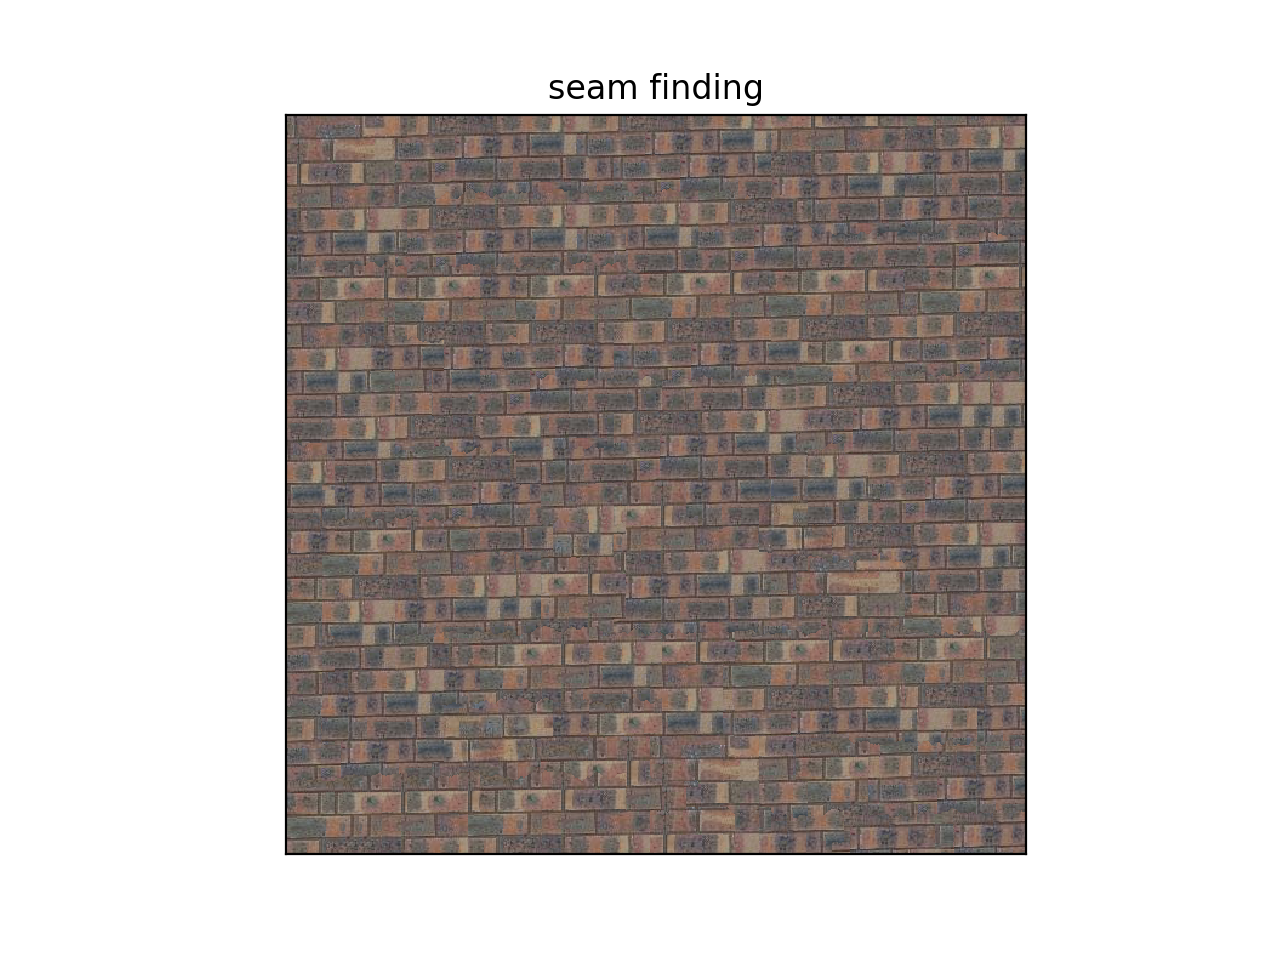

[]

In [9]:
res = quilt_cut(sample_img, 610, 40, 10, 0.001)

res = res.astype(np.uint8)

res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,1)
axes.imshow(res)
axes.set_title('seam finding')
axes.set_xticks([])
axes.set_yticks([])

In [10]:
def plot_overlap(sample, patch_size, overlap, tol):
    mask_top = np.zeros((patch_size, patch_size, 3))
    mask_top[:overlap, :, :] = 1
    
    result = np.zeros((patch_size, patch_size*2-overlap, 3))

    loc_r = random.randint(0, sample.shape[0]-patch_size)
    loc_c = random.randint(0, sample.shape[1]-patch_size)
    
    result[:patch_size, :patch_size, :] = sample[loc_r:loc_r+patch_size, loc_c:loc_c+patch_size, :].copy()
    
    replace = result[:patch_size, : patch_size, :]
    ssd = ssd_patch(replace, mask_top, sample)
    ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
    (row, col) = choose_sample(ssd, tol)
    new_patch = sample[row:row+patch_size, col:col+patch_size,:].copy()
        
        #diff = ssd_patch(new_patch[:overlap, :patch_size, :], replace[:overlap,: patch_size, :], ones1)
        
        
    diff = replace[:overlap,: patch_size, :]**2 - new_patch[:overlap, :patch_size, :]**2
    diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
        
    mask, path = cut(diff)
    
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(cv2.cvtColor(replace[:overlap,: patch_size, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(cv2.cvtColor(new_patch[:overlap, :patch_size, :].astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].imshow(np.absolute(diff/255).astype(np.uint8))
    axes[2].plot(np.linspace(0, 39, num=40), path, '-', linewidth=2, color='firebrick')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

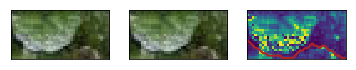

In [11]:
plot_overlap(sample_img, 40, 20, 0.9)

### part IV: Texture Transfer (30 pts)

In [12]:
def texture_transfer(sample, target, alpha):
    """
    Feel free to add function parameters
    """
    (r, c, _) = target.shape
    p_size = 15
    tol = 0.0001
    overlap = 3
    
    mask_left = np.zeros((p_size, p_size, 3))
    mask_left[:, :overlap,:] = 1
    
    mask_top = np.zeros((p_size, p_size, 3))
    mask_top[:overlap, :, :] = 1
    
    mask_other = np.zeros((p_size, p_size, 3))
    mask_other[:, :overlap, :] = 1
    mask_other[:overlap, :, :] = 1
    
    ones = np.ones((p_size, p_size, 3))
    
    result = np.zeros((r, c, 3))
    rows = (r-overlap) // (p_size-overlap)
    cols = (c-overlap) // (p_size-overlap)

    '''
    loc_r = random.randint(0, sample.shape[0]-patch_size)
    loc_c = random.randint(0, sample.shape[1]-patch_size)
    '''
    
    #result[:patch_size, :patch_size, :] = sample[loc_r:loc_r+patch_size, loc_c:loc_c+patch_size, :].copy()
    
    for i in range(0, rows):
        
        replace = result[i*(p_size-overlap):i*(p_size-overlap)+p_size, : p_size, :]
        target_patch = target[i*(p_size-overlap):i*(p_size-overlap)+p_size, : p_size, :]
        ssd_overlap = ssd_patch(replace, mask_top, sample)
        ssd_target = ssd_patch(target_patch, ones, sample)
        ssd_overlap = ssd_overlap[p_size//2:-p_size//2, p_size//2:-p_size//2]
        ssd_target = ssd_target[p_size//2:-p_size//2, p_size//2:-p_size//2]
        
        (row, col) = choose_sample(ssd_overlap*alpha+ssd_target*(1-alpha), tol)
        new_patch = sample[row:row+p_size, col:col+p_size,:].copy()
        
        diff = replace[:overlap,: p_size, :] - new_patch[:overlap, :p_size, :]
        diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
        mask = cut(diff)
        
        mask = mask.astype(np.uint8)
        
        new_patch[:overlap,:p_size,0] *= mask
        new_patch[:overlap,:p_size,1] *= mask
        new_patch[:overlap,:p_size,2] *= mask
        
        inv_mask = np.ones(mask.shape)-mask
        
        replace[:overlap,:p_size,0] *= inv_mask
        replace[:overlap,:p_size,1] *= inv_mask
        replace[:overlap,:p_size,2] *= inv_mask
        
        replace += new_patch
            
    for i in range(1, cols):
        replace = result[:p_size, i*(p_size-overlap):i*(p_size-overlap)+p_size,:]
        target_patch = target[:p_size, i*(p_size-overlap):i*(p_size-overlap)+p_size,:]
        ssd_overlap = ssd_patch(replace, mask_left, sample)
        ssd_target = ssd_patch(target_patch, ones, sample)
        ssd_overlap = ssd_overlap[p_size//2:-p_size//2, p_size//2:-p_size//2]
        ssd_target = ssd_target[p_size//2:-p_size//2, p_size//2:-p_size//2]
        
        (row, col) = choose_sample(ssd_overlap*alpha+ssd_target*(1-alpha), tol)
        new_patch = sample[row:row+p_size, col:col+p_size,:].copy()
        
        diff = replace[: p_size,:overlap, :] - new_patch[:p_size,:overlap, :]
        diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
        mask = cut(diff)
        
        mask = mask.astype(np.uint8)
        
        new_patch[:p_size,:overlap,0] *= mask
        new_patch[:p_size,:overlap,1] *= mask
        new_patch[:p_size,:overlap,2] *= mask
        
        inv_mask = np.ones(mask.shape)-mask
        
        replace[:p_size,:overlap,0] *= inv_mask
        replace[:p_size,:overlap,1] *= inv_mask
        replace[:p_size,:overlap,2] *= inv_mask
        
        
        
        replace += new_patch
            
    
    for i in range(1, rows):
        for j in range(1, cols):
            target_patch = target[i*(p_size-overlap):i*(p_size-overlap)+p_size, \
                                   j*(p_size-overlap):j*(p_size-overlap)+p_size, :]
            replace = result[i*(p_size-overlap):i*(p_size-overlap)+p_size, \
                                   j*(p_size-overlap):j*(p_size-overlap)+p_size, :]
            
            
            ssd_overlap = ssd_patch(replace, mask_other, sample)
            ssd_target = ssd_patch(target_patch, ones, sample)
            ssd_overlap = ssd_overlap[p_size//2:-p_size//2, p_size//2:-p_size//2]
            ssd_target = ssd_target[p_size//2:-p_size//2, p_size//2:-p_size//2]
        
            (row, col) = choose_sample(ssd_overlap*alpha+ssd_target*(1-alpha), tol)
            new_patch = sample[row:row+p_size, col:col+p_size,:].copy()
            
            diff = replace[:overlap,: p_size, :] - new_patch[:overlap, :p_size, :]
            diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
            mask1 = cut(diff)
            
            diff = replace[: p_size,:overlap, :] - new_patch[:p_size,:overlap, :]
            diff = diff[:,:,0]+diff[:,:,1]+diff[:,:,2]
            mask2 = cut(diff)
            
            
            mask_combined = np.ones((p_size, p_size))
            mask_combined[:overlap,:p_size] *= mask1
            
            mask_combined[:p_size,:overlap] *= mask2
            
            mask_combined = mask_combined.astype(np.uint8)
        
        
            new_patch[:,:,0] *= mask_combined
            new_patch[:,:,1] *= mask_combined
            new_patch[:,:,2] *= mask_combined
        
            inv_mask = np.ones(mask_combined.shape)-mask_combined
        
            replace[:, :,0] *= inv_mask
            replace[:,:,1] *= inv_mask
            replace[:,:,2] *= inv_mask
            
            replace += new_patch
            
            
    return result

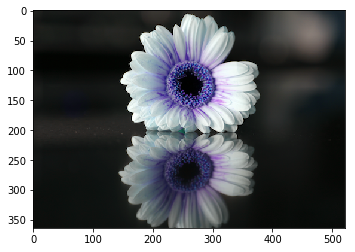

In [13]:
img = cv2.imread('samples/5.jpg')
plt.imshow(img)

target = cv2.imread('samples/flower_small.png')
plt.imshow(target)

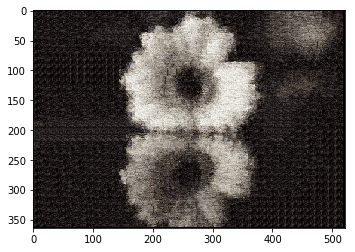

In [14]:

res = texture_transfer(img, target, 0.5)


res = res.astype(np.uint8)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).